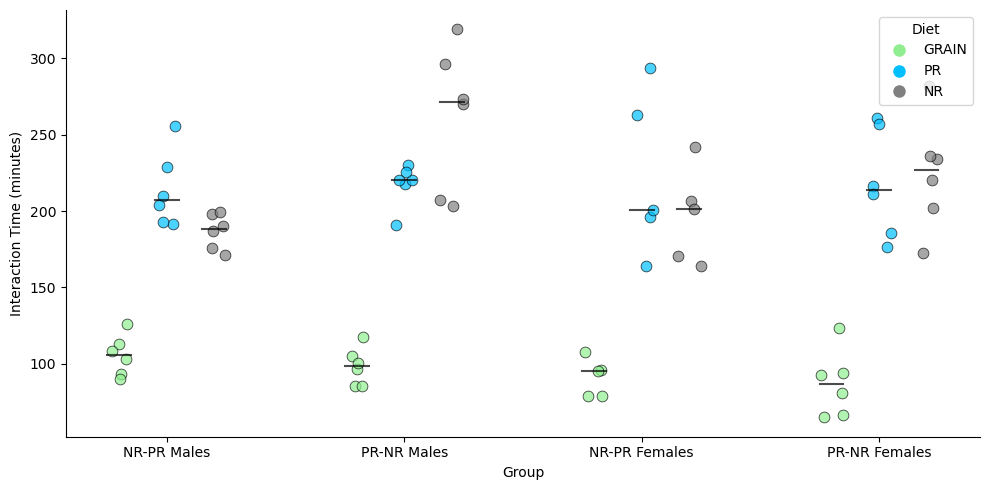

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the interaction times CSV file
interaction_data = pd.read_csv("../results/mice_interaction_times.csv")

# Group selectors based on your criteria
nrpr_male_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'M')
prnr_male_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'M')
nrpr_female_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'F')
prnr_female_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'F')

# Extract data for each group and phase
nrpr_male_data = interaction_data[nrpr_male_selector][['grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']]
prnr_male_data = interaction_data[prnr_male_selector][['grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']]
nrpr_female_data = interaction_data[nrpr_female_selector][['grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']]
prnr_female_data = interaction_data[prnr_female_selector][['grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']]

# Combine all data for easier plotting
data = [
    nrpr_male_data['grain_interaction_time'], nrpr_male_data['pr_interaction_time'], nrpr_male_data['nr_interaction_time'],
    prnr_male_data['grain_interaction_time'], prnr_male_data['pr_interaction_time'], prnr_male_data['nr_interaction_time'],
    nrpr_female_data['grain_interaction_time'], nrpr_female_data['pr_interaction_time'], nrpr_female_data['nr_interaction_time'],
    prnr_female_data['grain_interaction_time'], prnr_female_data['pr_interaction_time'], prnr_female_data['nr_interaction_time']
]

group_labels = [
    "NR-PR Males (GRAIN)", "NR-PR Males (PR)", "NR-PR Males (NR)",
    "PR-NR Males (GRAIN)", "PR-NR Males (PR)", "PR-NR Males (NR)",
    "NR-PR Females (GRAIN)", "NR-PR Females (PR)", "NR-PR Females (NR)",
    "PR-NR Females (GRAIN)", "PR-NR Females (PR)", "PR-NR Females (NR)"
]

colors = {"GRAIN": "lightgreen", "PR": "deepskyblue", "NR": "grey"}
offset = {"GRAIN": -0.2, "PR": 0, "NR": 0.2}
group_mapping = {
    "NR-PR Males (GRAIN)": ("NR-PR Males", "GRAIN"),
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (GRAIN)": ("PR-NR Males", "GRAIN"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (GRAIN)": ("NR-PR Females", "GRAIN"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (GRAIN)": ("PR-NR Females", "GRAIN"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the scatter plot
jitter_strength = 0.05  # Jitter for spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=60, alpha=0.7, edgecolor="black")

# Add median lines
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["GRAIN", "PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.05, x_val + 0.05], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
custom_lines = [
    plt.Line2D([0], [0], color=colors["GRAIN"], marker='o', linestyle='', markersize=8, label='GRAIN'),
    plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
    plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')
]
plt.legend(handles=custom_lines, title="Diet", loc="upper right")

# Customize the plot aesthetics
plt.xticks(
    [group_positions["NR-PR Males"], group_positions["PR-NR Males"],
     group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
    ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Interaction Time (minutes)")

# Remove grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


# cell below updates interaction times code

In [1]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

# Function to read FED3 events and extract timestamps for multiple interaction events
def get_FEDevents(filename, eventnames):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows:
        if row[7] in eventnames:  # Check for any of the event names (pokes, pellet retrievals, etc.)
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    return timestamps

# Function to calculate the total interaction time based on timestamps
def calculate_interaction_time(timestamps):
    if len(timestamps) < 2:
        return 0  # No interactions if fewer than 2 timestamps

    # Calculate time differences between consecutive events
    interaction_times = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]

    # Consider interactions that happen within 1 minute as continuous
    threshold_seconds = 60
    total_interaction_time = sum([t for t in interaction_times if t <= threshold_seconds])

    # Return the total interaction time in minutes
    return total_interaction_time / 60

# Processing the metafile data to extract relevant timestamps for each mouse
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

# Modify this section to include multiple event types for interaction
event_types = ['Pellet', 'LeftPoke', 'RightPoke', 'PokeWithPellet']  # Add all relevant interaction events

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":  # Focus on free-feeding mode
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, event_types)
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Calculate interaction times and store them in the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Calculate interaction time for each phase
    mice[key]["grain_interaction_time"] = calculate_interaction_time(grain_timestamps)
    mice[key]["pr_interaction_time"] = calculate_interaction_time(pr_timestamps)
    mice[key]["nr_interaction_time"] = calculate_interaction_time(nr_timestamps)

# Function to save interaction times to a CSV
def save_interaction_times_to_csv(mice_data, output_filename):
    with open(output_filename, mode='w', newline='') as file:
        fieldnames = ['mouse_id', 'sex', 'order', 'grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write interaction time data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {
                'mouse_id': mouse_id,
                'sex': mouse_data.get('sex', None),
                'order': mouse_data.get('order', None),
                'grain_interaction_time': mouse_data.get('grain_interaction_time', None),
                'pr_interaction_time': mouse_data.get('pr_interaction_time', None),
                'nr_interaction_time': mouse_data.get('nr_interaction_time', None)
            }
            writer.writerow(row_data)

# Save the interaction times to a CSV file
output_filename = '../results/mice_interaction_times_Updated.csv'  
save_interaction_times_to_csv(mice, output_filename)


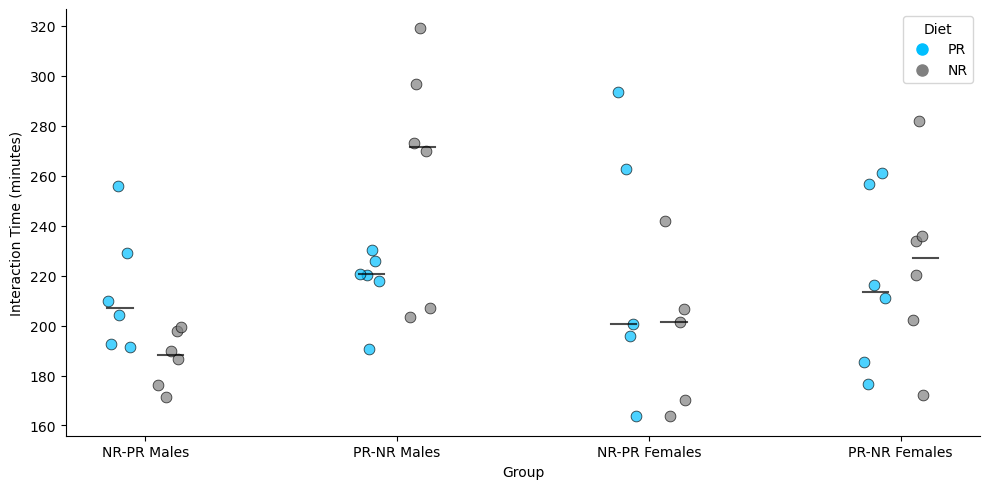

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the interaction times CSV file
interaction_data = pd.read_csv("../results/mice_interaction_times_Updated.csv")

# Group selectors based on your criteria
nrpr_male_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'M')
prnr_male_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'M')
nrpr_female_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'F')
prnr_female_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'F')

# Extract data for each group and phase, but only for PR and NR
nrpr_male_data = interaction_data[nrpr_male_selector][['pr_interaction_time', 'nr_interaction_time']]
prnr_male_data = interaction_data[prnr_male_selector][['pr_interaction_time', 'nr_interaction_time']]
nrpr_female_data = interaction_data[nrpr_female_selector][['pr_interaction_time', 'nr_interaction_time']]
prnr_female_data = interaction_data[prnr_female_selector][['pr_interaction_time', 'nr_interaction_time']]

# Combine all data for easier plotting
data = [
    nrpr_male_data['pr_interaction_time'], nrpr_male_data['nr_interaction_time'],
    prnr_male_data['pr_interaction_time'], prnr_male_data['nr_interaction_time'],
    nrpr_female_data['pr_interaction_time'], nrpr_female_data['nr_interaction_time'],
    prnr_female_data['pr_interaction_time'], prnr_female_data['nr_interaction_time']
]

group_labels = [
    "NR-PR Males (PR)", "NR-PR Males (NR)",
    "PR-NR Males (PR)", "PR-NR Males (NR)",
    "NR-PR Females (PR)", "NR-PR Females (NR)",
    "PR-NR Females (PR)", "PR-NR Females (NR)"
]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Adjust offsets for PR and NR
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the scatter plot
jitter_strength = 0.05  # Jitter for spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=60, alpha=0.7, edgecolor="black")

# Add median lines
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.05, x_val + 0.05], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
custom_lines = [
    plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
    plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')
]
plt.legend(handles=custom_lines, title="Diet", loc="upper right")

# Customize the plot aesthetics
plt.xticks(
    [group_positions["NR-PR Males"], group_positions["PR-NR Males"],
     group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
    ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Interaction Time (minutes)")

# Remove grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()
